
[Protein counts per group]
cla       : 13066
nocla     : 3728
uncon     : 19462

[Tests vs uncon]
cla         p = 0.000e+00,  delta = +0.641
nocla       p = 1.767e-190,  delta = +0.328


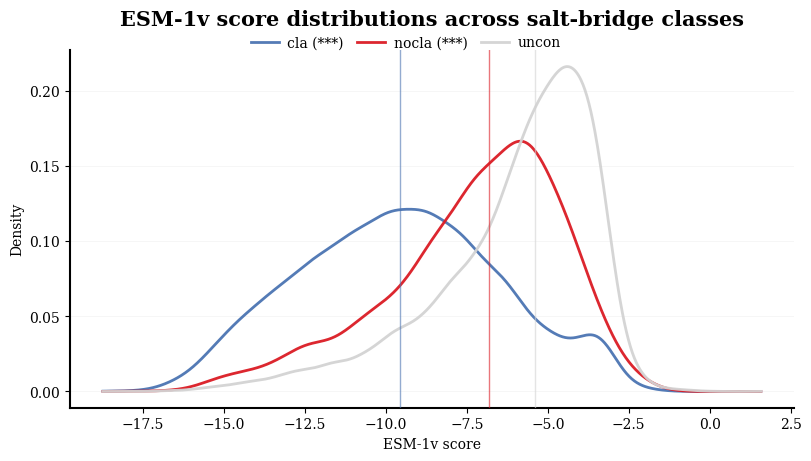

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

# --------------- 路径 & 参数 ---------------

csv_files = {
    'cla':        "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-cla_with_mean.csv",
    'nocla':      "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-nocla_with_mean.csv",
    #'semi-cla':   "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-half-cla_with_mean.csv",
    #'semi-nocla': "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-half-nocla_with_mean.csv",
    'uncon':      "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-uncon_with_mean.csv",
}
# 绘图顺序
#order  = ['cla','nocla','semi-cla','semi-nocla','uncon']
order  = ['cla','nocla','uncon']
# 每蛋白聚合方式：median 或 mean
AGG = 'median'

# 统一配色
colors = {
    'cla':        '#4B74B2',
    'nocla':      '#DB1B24',
    #'semi-cla':   '#90BEE0',
    #'semi-nocla': '#FC8C5A',
    'uncon':      '#D3D3D3'
}

# 字体/样式（Times 风格回退）
mpl.rcParams['font.family'] = ['DejaVu Serif','Liberation Serif','Nimbus Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.5


# --------------- 工具函数 ---------------

def agg_func(x, how='median'):
    x = np.asarray(x)
    return np.median(x) if how=='median' else np.mean(x)

def cliffs_delta(x, y, max_pairs=200000):
    """
    Cliff's delta：
    这里定义为 delta = (uncon − group) 的方向：
    x: uncon, y: 其他组
    返回 δ∈[-1,1]；δ>0 表示 uncon 倾向更大（组更偏负一点）
    """
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx * ny > max_pairs:
        rng = np.random.default_rng(0)
        x = rng.choice(x, size=min(nx, int(np.sqrt(max_pairs))), replace=False)
        y = rng.choice(y, size=min(ny, int(np.sqrt(max_pairs))), replace=False)
    gt = lt = 0
    for xi in x:
        lt += np.sum(xi < y)
        gt += np.sum(xi > y)
    return (gt - lt) / (len(x) * len(y))

def p_to_star(p):
    """把 p 值转成 *, **, *** 或 ns"""
    if p < 1e-3:
        return '***'
    elif p < 1e-2:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'


# --------------- 读取并聚合到“每蛋白” ---------------

prot_scores = {}   # 每组：Series(uniprotid -> 蛋白级分数)

for g in order:
    df = pd.read_csv(csv_files[g])
    # 这里假设 csv 里有列：uniprotid, mean_score
    s  = df.groupby('uniprotid')['mean_score'].apply(
        lambda v: agg_func(v.values, AGG)
    )
    prot_scores[g] = s

print("\n[Protein counts per group]")
for g in order:
    print(f"{g:10s}: {prot_scores[g].shape[0]}")


# --------------- 统计检验：每组 vs uncon ---------------

ref = 'uncon'
tests = {}

x_ref = prot_scores[ref].values

for g in order:
    if g == ref:
        continue
    y = prot_scores[g].values
    # Mann–Whitney U 检验（双侧）
    U, p = stats.mannwhitneyu(y, x_ref, alternative='two-sided')
    # Cliff's delta（uncon − group）
    delta = cliffs_delta(x_ref, y)
    tests[g] = dict(p=p, delta=delta)

print("\n[Tests vs uncon]")
for g in order:
    if g == ref:
        continue
    print(f"{g:10s}  p = {tests[g]['p']:.3e},  delta = {tests[g]['delta']:+.3f}")


# =========================================================
# 图：KDE + 各组中位数（不画 HDI 带）
# =========================================================

# 所有蛋白分数拼在一起，用于确定 x 轴范围
all_vals = np.concatenate([prot_scores[g].values for g in order])
xgrid = np.linspace(all_vals.min(), all_vals.max(), 1000)

fig, ax = plt.subplots(figsize=(8.0, 4.5), constrained_layout=True)

# 1) KDE 曲线
for g in order:
    vals = prot_scores[g].values
    if len(vals) >= 5:
        kde = stats.gaussian_kde(vals)
        ax.plot(
            xgrid,
            kde(xgrid),
            lw=2.0,
            color=colors[g],
            label=g,
            alpha=0.95,
            zorder=2
        )

# 2) 中位数竖线
for g in order:
    med = np.median(prot_scores[g].values)
    ax.axvline(
        med,
        color=colors[g],
        ls='-',
        lw=1.0,
        alpha=0.6,
        zorder=3
    )

# 轴与标题（英文简洁版）
ax.set_xlabel('ESM-1v score', fontsize=10)
ax.set_ylabel('Density')
ax.set_title(
    'ESM-1v score distributions across salt-bridge classes',
    pad=18,
    fontsize=15,
    fontweight='bold'
)

# 3) 图例：把检验结果写进 label
# 只保留 p 值的星号
handles, labels = ax.get_legend_handles_labels()

def p_to_star(p):
    if p < 1e-3:
        return '***'
    elif p < 1e-2:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

new_labels = []
for lab in labels:
    g = lab
    if g == 'uncon':
        new_labels.append('uncon')
    else:
        p = tests[g]['p']
        star = p_to_star(p)
        new_labels.append(f"{g} ({star})")

fig.legend(
    handles, new_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.96),
    bbox_transform=fig.transFigure,
    ncol=len(new_labels),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.0
)


# 美化
ax.grid(axis='y', alpha=0.12, lw=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 注意：不要 bbox_inches='tight'，避免把画布外的 legend 裁掉
fig.savefig('esm_KDE_medians_with_tests.png', dpi=600, facecolor='white')
plt.show()



[Protein counts per group]
cla       : 13,066
nocla     : 3,728
uncon     : 19,462

[Protein-level summary]
cla       : n=13,066  mean=-9.5610  sd=3.1033  median=-9.5699
nocla     : n=3,728  mean=-7.2741  sd=2.7118  median=-6.8144
uncon     : n=19,462  mean=-6.0052  sd=2.4797  median=-5.3989

[1] Kruskal–Wallis (overall, protein-level)
  H = 9640.044259, p = 0.000e+00, epsilon^2 = 0.265855

[2] Dunn post-hoc (Holm adjusted)
group1 group2          z         p_raw         p_adj
   cla  uncon -98.180721  0.000000e+00  0.000000e+00
   cla  nocla -35.065519 2.262019e-269 4.524039e-269
 nocla  uncon -25.692262 1.426462e-145 1.426462e-145

[3] Cliff's delta (pairwise)
group1 group2  cliffs_delta
   cla  nocla     -0.433519
   cla  uncon     -0.630080
 nocla  uncon     -0.303867

Saved tables: esm_dunn_holm_proteinlevel.csv, esm_cliffs_delta_proteinlevel.csv

Saved figure: esm_KDE_medians_DunnHolm.png


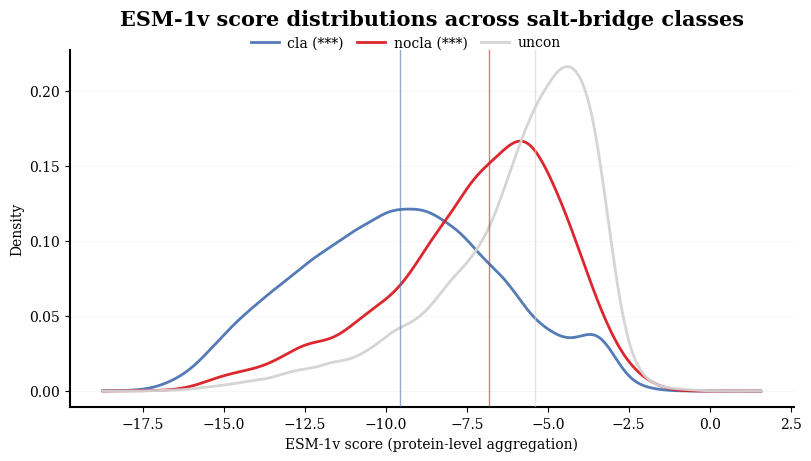

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy.stats import norm
from itertools import combinations

# --------------- 路径 & 参数 ---------------

csv_files = {
    'cla':   "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-cla_with_mean.csv",
    'nocla': "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-nocla_with_mean.csv",
    'uncon': "/home/databank_70t/pengziyu/scop/251105/4+1/ESM-output/resultESM-uncon_with_mean.csv",
}

# 绘图顺序
order = ['cla', 'nocla', 'uncon']

# 每蛋白聚合方式：'median' 或 'mean'
AGG = 'median'

# 统一配色
colors = {
    'cla':   '#4B74B2',
    'nocla': '#DB1B24',
    'uncon': '#D3D3D3'
}

# 字体/样式（Times 风格回退）
mpl.rcParams['font.family'] = ['DejaVu Serif', 'Liberation Serif', 'Nimbus Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.5


# --------------- 工具函数 ---------------

def _clean(x):
    x = np.asarray(x, dtype=float)
    return x[np.isfinite(x)]

def agg_func(x, how='median'):
    x = _clean(x)
    return float(np.median(x)) if how == 'median' else float(np.mean(x))

def p_to_star(p):
    if p < 1e-3:
        return '***'
    elif p < 1e-2:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def cliffs_delta_fast(a, b):
    """Cliff's delta: delta = P(a>b) - P(a<b). delta>0 means a tends to be larger than b."""
    a = _clean(a); b = _clean(b)
    if len(a) == 0 or len(b) == 0:
        return np.nan
    a_sorted = np.sort(a)
    b_sorted = np.sort(b)
    m = len(b_sorted)
    greater = np.sum(np.searchsorted(b_sorted, a_sorted, side="left"))
    less = np.sum(m - np.searchsorted(b_sorted, a_sorted, side="right"))
    return float((greater - less) / (len(a_sorted) * m))

def kruskal_with_eps2(groups_list):
    """groups_list: [arr1, arr2, ...]"""
    H, p = stats.kruskal(*groups_list, nan_policy="omit")
    n = sum(len(g) for g in groups_list)
    k = len(groups_list)
    eps2 = (H - k + 1) / (n - k) if (n > k) else np.nan
    eps2 = max(0.0, eps2) if np.isfinite(eps2) else eps2
    return H, p, eps2

def dunn_posthoc(data_dict, category_order, p_adjust="holm"):
    """
    Dunn post-hoc test with tie correction.
    Returns DataFrame: group1, group2, z, p_raw, p_adj
    """
    values = []
    groups = []
    for g in category_order:
        x = _clean(data_dict[g])
        values.append(x)
        groups.append(np.array([g] * len(x), dtype=object))
    x_all = np.concatenate(values)
    g_all = np.concatenate(groups)

    N = len(x_all)
    ranks = stats.rankdata(x_all, method="average")

    # tie correction term
    _, tie_counts = np.unique(x_all, return_counts=True)
    tie_term = np.sum(tie_counts**3 - tie_counts)
    A = (N * (N + 1) / 12.0) - (tie_term / (12.0 * (N - 1))) if N > 1 else np.nan

    mean_rank = {}
    n_group = {}
    for g in category_order:
        mask = (g_all == g)
        mean_rank[g] = float(ranks[mask].mean())
        n_group[g] = int(mask.sum())

    results = []
    for a, b in combinations(category_order, 2):
        se = np.sqrt(A * (1.0 / n_group[a] + 1.0 / n_group[b]))
        z = (mean_rank[a] - mean_rank[b]) / se
        p_raw = 2.0 * norm.sf(abs(z))
        results.append((a, b, float(z), float(p_raw)))

    res_df = pd.DataFrame(results, columns=["group1", "group2", "z", "p_raw"])

    # multiple testing adjustment
    m = len(res_df)
    pvals = res_df["p_raw"].values

    if p_adjust.lower() == "holm":
        order = np.argsort(pvals)
        adj = np.empty(m, dtype=float)
        prev = 0.0
        for i, idx in enumerate(order):
            p_adj_i = (m - i) * pvals[idx]
            p_adj_i = min(1.0, p_adj_i)
            p_adj_i = max(prev, p_adj_i)  # enforce monotonicity
            adj[idx] = p_adj_i
            prev = p_adj_i
        res_df["p_adj"] = adj
    elif p_adjust.lower() in ["fdr_bh", "bh", "fdr"]:
        order = np.argsort(pvals)
        adj = np.empty(m, dtype=float)
        prev = 1.0
        for i in range(m - 1, -1, -1):
            idx = order[i]
            rank = i + 1
            p_adj_i = pvals[idx] * m / rank
            p_adj_i = min(prev, p_adj_i, 1.0)
            adj[idx] = p_adj_i
            prev = p_adj_i
        res_df["p_adj"] = adj
    else:
        res_df["p_adj"] = res_df["p_raw"]

    return res_df.sort_values("p_adj").reset_index(drop=True)


# --------------- 读取并聚合到“每蛋白” ---------------

prot_scores = {}   # 每组：Series(uniprotid -> 蛋白级分数)

for g in order:
    df = pd.read_csv(csv_files[g])

    # 这里假设 csv 里有列：uniprotid, mean_score
    if 'uniprotid' not in df.columns:
        raise ValueError(f"[{g}] missing column: uniprotid")
    if 'mean_score' not in df.columns:
        raise ValueError(f"[{g}] missing column: mean_score")

    s = df.groupby('uniprotid')['mean_score'].apply(lambda v: agg_func(v.values, AGG))
    prot_scores[g] = s

print("\n[Protein counts per group]")
for g in order:
    print(f"{g:10s}: {prot_scores[g].shape[0]:,}")

print("\n[Protein-level summary]")
for g in order:
    vals = _clean(prot_scores[g].values)
    print(f"{g:10s}: n={len(vals):,}  mean={vals.mean():.4f}  sd={vals.std():.4f}  median={np.median(vals):.4f}")


# --------------- 统计检验：Kruskal–Wallis + Dunn-Holm + Cliff’s δ ---------------

data_for_stats = {g: _clean(prot_scores[g].values) for g in order}

# Overall KW
H, p_kw, eps2 = kruskal_with_eps2([data_for_stats[g] for g in order])
print("\n[1] Kruskal–Wallis (overall, protein-level)")
print(f"  H = {H:.6f}, p = {p_kw:.3e}, epsilon^2 = {eps2:.6f}")

# Dunn post-hoc (Holm adjusted)
dunn_df = dunn_posthoc(data_for_stats, order, p_adjust="holm")
print("\n[2] Dunn post-hoc (Holm adjusted)")
print(dunn_df.to_string(index=False))

# Pairwise Cliff's delta (aligned with Dunn pairs: group1 vs group2)
rows = []
for a, b in combinations(order, 2):
    d = cliffs_delta_fast(data_for_stats[a], data_for_stats[b])
    rows.append([a, b, d])
cliff_df = pd.DataFrame(rows, columns=["group1", "group2", "cliffs_delta"])
print("\n[3] Cliff's delta (pairwise)")
print(cliff_df.to_string(index=False))

# Optional: save stats tables
dunn_df.to_csv("esm_dunn_holm_proteinlevel.csv", index=False)
cliff_df.to_csv("esm_cliffs_delta_proteinlevel.csv", index=False)
print("\nSaved tables: esm_dunn_holm_proteinlevel.csv, esm_cliffs_delta_proteinlevel.csv")

# For legend stars: use Holm-adjusted p for (group vs uncon)
ref = "uncon"
tests_vs_uncon = {}
for _, r in dunn_df.iterrows():
    a, b = r["group1"], r["group2"]
    if {a, b} == {ref, "cla"}:
        tests_vs_uncon["cla"] = float(r["p_adj"])
    if {a, b} == {ref, "nocla"}:
        tests_vs_uncon["nocla"] = float(r["p_adj"])


# =========================================================
# 图：KDE + 各组中位数（蛋白级分数）
# =========================================================

all_vals = np.concatenate([data_for_stats[g] for g in order])
xgrid = np.linspace(all_vals.min(), all_vals.max(), 1000)

fig, ax = plt.subplots(figsize=(8.0, 4.5), constrained_layout=True)

# 1) KDE 曲线
for g in order:
    vals = data_for_stats[g]
    if len(vals) >= 5:
        kde = stats.gaussian_kde(vals)
        ax.plot(
            xgrid,
            kde(xgrid),
            lw=2.0,
            color=colors[g],
            label=g,
            alpha=0.95,
            zorder=2
        )

# 2) 中位数竖线
for g in order:
    med = float(np.median(data_for_stats[g]))
    ax.axvline(
        med,
        color=colors[g],
        ls='-',
        lw=1.0,
        alpha=0.6,
        zorder=3
    )

# 轴与标题（英文简洁版）
ax.set_xlabel('ESM-1v score (protein-level aggregation)', fontsize=10)
ax.set_ylabel('Density')
ax.set_title(
    'ESM-1v score distributions across salt-bridge classes',
    pad=18,
    fontsize=15,
    fontweight='bold'
)

# 3) 图例：把 vs uncon 的检验结果写进 label（Holm校正后）
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    g = lab
    if g == ref:
        new_labels.append(ref)
    else:
        p_adj = tests_vs_uncon.get(g, np.nan)
        star = p_to_star(p_adj) if np.isfinite(p_adj) else "na"
        new_labels.append(f"{g} ({star})")

fig.legend(
    handles, new_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.96),
    bbox_transform=fig.transFigure,
    ncol=len(new_labels),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.0
)

# 美化
ax.grid(axis='y', alpha=0.12, lw=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 注意：不要 bbox_inches='tight'，避免把画布外的 legend 裁掉
out_png = "esm_KDE_medians_DunnHolm.png"
fig.savefig(out_png, dpi=600, facecolor='white')
print(f"\nSaved figure: {out_png}")

plt.show()
